<a href="https://colab.research.google.com/github/ramrajv/RNN_Gesture_Recognition_Project/blob/main/Gesture_Recognition_Ram_Prayag_Submit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition 
<p align = 'right'>A case study by Ramraj and Prayag</p>
<p align = 'right'>Completed in June 2022</p>

## Introduction

In this group project, we are using the principles of deep learning to predict the gestures correctly from short video clips. 

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
<ul>
    <li>Thumbs up:  Increase the volume.</li>
    <li>Thumbs down: Decrease the volume.</li>
    <li>Left swipe: 'Jump' backwards 10 seconds</li>
    <li>Right swipe: 'Jump' forward 10 seconds</li>
    <li>Palm gesture: Pause the movie</li>
</ul>

## Dataset

It consist of 663 videos recorded for training, each video frame being saved a an image on the filesystem. There are 30 frames for each video. Further there are 100 videos of 30 frames each to validate the accuracy of the solution.

## Approach

We will use following three deep learning architectures to come up with an optimum model
<ol>
    <li>3D Convolutional layers model.</li>
    <li>2D Convolutional layers for feature identification + RNN layers (LSTM + GRU) for gesture recognition.</li>
    <li>Use transfer learning with a pre-builit model such as MobileNet for feature detection + RNN layers (LSTM + GRU) for gesture recognition.</li>
</ol>


In [ ]:
# we will use an older version of scipy as newer version does not have imread and imresize methods

In [ ]:
# !pip install scipy==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.2 MB 291 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.4 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
jax 0.3.8 requires scipy>=1.2.1, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# Import packages and libraries

import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [ ]:
# following is needed when running on Google colab
# we will mount our Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# set random seed that each run produces all most same results

np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
# import libraries for image manipulation

import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
# import tensorflow and keras libraries

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout

<p>WARNING!: This folder is specific to the drive used by the study group. In order to use data for running this notebook, please specify the drive path correctly/ path to the folder as necessary.</p>

In [ ]:
# set the path for the root of the data folder

project_folder='/content/drive/MyDrive/AI_MSc_Upgrad/UpgradPt2/Gesture_Project/Project_data'

### Plotting

<p>Function to plot validation and training metrics</p>

In [ ]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Model Builder class

We will create a model builder class, which allows us to

- intitialise paths etc
- initialise image properties
- set hyperparameters
- define the generator function and helper methods
- train model method

Creating a class allows to reuse the code when running with different hyperparamters and also with differnt model archtiectures.

We will create a generator method, which will feed in the image data to the model in specifed number of batches. The reason is the CPU/GPU can fit only a small of amount of data.

In [ ]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    # method to initialise the paths and number of sequences

    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    
    # initialise image properties

    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30

    # Set hyperparameters

    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # Define generator function

    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size  # get whole number of batches
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size   # get balance number in the last batch
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    # get one batch of data

    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size

        # define the matrix for the image data and the label data

        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 

            # get list of the images in the video directory

            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                # read an image
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                # resize image
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                # normalize image data
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                # create new images by augmentation

                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                               
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
        # Concatenate augmented images

        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    # method to train a model
    
    def train_model(self, model, augment_data=False):

        # create the train and validation generator

        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        # we will save best model information in *.h5 file

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        # create model check point to save model when validation less goes down

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        # set number of steps per epochs so that correct number batch generator calls are made

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
        
        # fit the model
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model Building Excercise

We will create different models as described in our approach. The objective is 
to design the network in such a way that the model is able to give good accuracy with the least number of parameters.

## Sample Model

We will build a sample model to test if the code is working right

In [ ]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

##### Sample Cropping

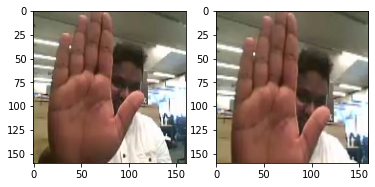

In [ ]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])

## Experiments

With
- Image resolution, 
- Number of frames to use and 
- batch_size

In [ ]:
#conv_3d1.train_model(conv_3d1_model)

### Memory limit reached

We had hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40...we get the below error

ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [ ]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.6621095314621925 Gigs


So lets trade-off between these parameters

### Experiments

Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.5800 - categorical_accuracy: 0.4133  
Epoch 1: saving model to model_init_2022-06-1400_41_49.061868/model-00001-1.58000-0.41327-2.67672-0.22000.h5
23/23 [==============================] - 4265s 193s/step - loss: 1.5800 - categorical_accuracy: 0.4133 - val_loss: 2.6767 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 1.0265 - categorical_accuracy: 0.5837
Epoch 2: saving model to model_init_2022-06-1400_41_49.061868/model-00002-1.02652-0.58371-4.66272-0.16000.h5
23/23 [==============================] - 71s 3s/step - loss: 1.0265 - categorical_accuracy: 0.5837 - val_loss: 4.6627 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 0.9366 - categorical_accuracy: 0.6214
Epoch 3: saving model to model_init_2022-06-1400_41_49.061868/model-00003-0.93655-0.62142-5.96717-0.22000.h

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.7166 - categorical_accuracy: 0.3891  
Epoch 1: saving model to model_init_2022-06-1401_58_12.046154/model-00001-1.71656-0.38914-2.04433-0.16000.h5
23/23 [==============================] - 3804s 173s/step - loss: 1.7166 - categorical_accuracy: 0.3891 - val_loss: 2.0443 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.2282 - categorical_accuracy: 0.5339
Epoch 2: saving model to model_init_2022-06-1401_58_12.046154/model-00002-1.22819-0.53394-2.84185-0.19000.h5
23/23 [==============================] - 120s 5s/step - loss: 1.2282 - categorical_accuracy: 0.5339 - val_loss: 2.8419 - val_categorical_accuracy: 0.1900 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
11/12 [==========================>...] - ETA: 9s - loss: 1.8284 - categorical_accuracy: 0.3818 
Epoch 1: saving model to model_init_2022-06-1403_07_04.256033/model-00001-1.82579-0.38311-1.87327-0.19000.h5
12/12 [==============================] - 125s 11s/step - loss: 1.8258 - categorical_accuracy: 0.3831 - val_loss: 1.8733 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/2
12/12 [==============================] - ETA: 0s - loss: 1.1603 - categorical_accuracy: 0.5249
Epoch 2: saving model to model_init_2022-06-1403_07_04.256033/model-00002-1.16025-0.52489-2.94969-0.11000.h5
12/12 [==============================] - 120s 11s/step - loss: 1.1603 - categorical_accuracy: 0.5249 - val_loss: 2.9497 - val_categorical_accuracy: 0.1100 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 1.6350 - categorical_accuracy: 0.3967
Epoch 1: saving model to model_init_2022-06-1403_11_37.457019/model-00001-1.63500-0.39668-1.60076-0.19000.h5
12/12 [==============================] - 68s 6s/step - loss: 1.6350 - categorical_accuracy: 0.3967 - val_loss: 1.6008 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/2
12/12 [==============================] - ETA: 0s - loss: 1.1240 - categorical_accuracy: 0.5777
Epoch 2: saving model to model_init_2022-06-1403_11_37.457019/model-00002-1.12401-0.57768-2.89377-0.13000.h5
12/12 [==============================] - 64s 6s/step - loss: 1.1240 - categorical_accuracy: 0.5777 - val_loss: 2.8938 - val_categorical_accuracy: 0.1300 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=80,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
9/9 [==============================] - ETA: 0s - loss: 1.8447 - categorical_accuracy: 0.3363
Epoch 1: saving model to model_init_2022-06-1403_13_54.540228/model-00001-1.84473-0.33635-1.63383-0.16000.h5
9/9 [==============================] - 63s 8s/step - loss: 1.8447 - categorical_accuracy: 0.3363 - val_loss: 1.6338 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
9/9 [==============================] - ETA: 0s - loss: 1.2348 - categorical_accuracy: 0.5158
Epoch 2: saving model to model_init_2022-06-1403_13_54.540228/model-00002-1.23482-0.51584-2.21154-0.18000.h5
9/9 [==============================] - 51s 6s/step - loss: 1.2348 - categorical_accuracy: 0.5158 - val_loss: 2.2115 - val_categorical_accuracy: 0.1800 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.5576 - categorical_accuracy: 0.4072
Epoch 1: saving model to model_init_2022-06-1403_15_55.541328/model-00001-1.55760-0.40724-3.66601-0.21000.h5
45/45 [==============================] - 116s 3s/step - loss: 1.5576 - categorical_accuracy: 0.4072 - val_loss: 3.6660 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.0828 - categorical_accuracy: 0.5626
Epoch 2: saving model to model_init_2022-06-1403_15_55.541328/model-00002-1.08276-0.56259-7.04717-0.25000.h5
45/45 [==============================] - 117s 3s/step - loss: 1.0828 - categorical_accuracy: 0.5626 - val_loss: 7.0472 - val_categorical_accuracy: 0.2500 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.6020 - categorical_accuracy: 0.4133
Epoch 1: saving model to model_init_2022-06-1403_19_50.864679/model-00001-1.60198-0.41327-5.99904-0.16000.h5
45/45 [==============================] - 63s 1s/step - loss: 1.6020 - categorical_accuracy: 0.4133 - val_loss: 5.9990 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.0594 - categorical_accuracy: 0.5882
Epoch 2: saving model to model_init_2022-06-1403_19_50.864679/model-00002-1.05941-0.58824-11.67852-0.14000.h5
45/45 [==============================] - 61s 1s/step - loss: 1.0594 - categorical_accuracy: 0.5882 - val_loss: 11.6785 - val_categorical_accuracy: 0.1400 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.6918 - categorical_accuracy: 0.3982
Epoch 1: saving model to model_init_2022-06-1403_21_55.835169/model-00001-1.69180-0.39819-3.68519-0.20000.h5
45/45 [==============================] - 59s 1s/step - loss: 1.6918 - categorical_accuracy: 0.3982 - val_loss: 3.6852 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.2199 - categorical_accuracy: 0.5324
Epoch 2: saving model to model_init_2022-06-1403_21_55.835169/model-00002-1.21995-0.53243-6.02808-0.15000.h5
45/45 [==============================] - 55s 1s/step - loss: 1.2199 - categorical_accuracy: 0.5324 - val_loss: 6.0281 - val_categorical_accuracy: 0.1500 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.6625 - categorical_accuracy: 0.3801
Epoch 1: saving model to model_init_2022-06-1403_24_19.937608/model-00001-1.66245-0.38009-3.53039-0.18000.h5
67/67 [==============================] - 56s 833ms/step - loss: 1.6625 - categorical_accuracy: 0.3801 - val_loss: 3.5304 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.1862 - categorical_accuracy: 0.5234
Epoch 2: saving model to model_init_2022-06-1403_24_19.937608/model-00002-1.18624-0.52338-4.34979-0.24000.h5
67/67 [==============================] - 57s 868ms/step - loss: 1.1862 - categorical_accuracy: 0.5234 - val_loss: 4.3498 - val_categorical_accuracy: 0.2400 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.6547 - categorical_accuracy: 0.3741
Epoch 1: saving model to model_init_2022-06-1403_26_14.517509/model-00001-1.65475-0.37406-4.66517-0.16000.h5
67/67 [==============================] - 103s 2s/step - loss: 1.6547 - categorical_accuracy: 0.3741 - val_loss: 4.6652 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.2742 - categorical_accuracy: 0.5038
Epoch 2: saving model to model_init_2022-06-1403_26_14.517509/model-00002-1.27422-0.50377-4.96577-0.16000.h5
67/67 [==============================] - 107s 2s/step - loss: 1.2742 - categorical_accuracy: 0.5038 - val_loss: 4.9658 - val_categorical_accuracy: 0.1600 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.6634 - categorical_accuracy: 0.3861
Epoch 1: saving model to model_init_2022-06-1403_29_46.224429/model-00001-1.66341-0.38612-5.45262-0.23000.h5
67/67 [==============================] - 114s 2s/step - loss: 1.6634 - categorical_accuracy: 0.3861 - val_loss: 5.4526 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.1279 - categorical_accuracy: 0.5566
Epoch 2: saving model to model_init_2022-06-1403_29_46.224429/model-00002-1.12785-0.55656-3.14985-0.26000.h5
67/67 [==============================] - 112s 2s/step - loss: 1.1279 - categorical_accuracy: 0.5566 - val_loss: 3.1499 - val_categorical_accuracy: 0.2600 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.5794 - categorical_accuracy: 0.4404
Epoch 1: saving model to model_init_2022-06-1403_33_34.524484/model-00001-1.57941-0.44042-8.10246-0.16000.h5
67/67 [==============================] - 67s 999ms/step - loss: 1.5794 - categorical_accuracy: 0.4404 - val_loss: 8.1025 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.1898 - categorical_accuracy: 0.5189
Epoch 2: saving model to model_init_2022-06-1403_33_34.524484/model-00002-1.18980-0.51885-6.37121-0.15000.h5
67/67 [==============================] - 61s 926ms/step - loss: 1.1898 - categorical_accuracy: 0.5189 - val_loss: 6.3712 - val_categorical_accuracy: 0.1500 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
17/17 [==============================] - ETA: 0s - loss: 1.5993 - categorical_accuracy: 0.4042
Epoch 1: saving model to model_init_2022-06-1403_35_58.520685/model-00001-1.59932-0.40422-1.86048-0.21000.h5
17/17 [==============================] - 67s 4s/step - loss: 1.5993 - categorical_accuracy: 0.4042 - val_loss: 1.8605 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
17/17 [==============================] - ETA: 0s - loss: 1.0062 - categorical_accuracy: 0.6139
Epoch 2: saving model to model_init_2022-06-1403_35_58.520685/model-00002-1.00617-0.61388-3.85833-0.22000.h5
17/17 [==============================] - 64s 4s/step - loss: 1.0062 - categorical_accuracy: 0.6139 - val_loss: 3.8583 - val_categorical_accuracy: 0.2200 - lr: 0.0010


### Observations

As we see from the above experiments <em>image resolution</em> and <em>number of frames</em> in sequence have a direct impact on training time than <em>batch_size</em>

### Conclusion of Experiments

- As a result of the above experiments, we fixed the <em>batch size between 15 and 40</em>. We changed the <em>resolution and number of image per sequence</em> based on the device memory constraints (100, 120 and 160). 
- Models are designed such that their memory foot print is less than 50 MB which corresponds to 4.3 million parameters assuming the datatype size of parameters to be 12 bytes.

# Model 1 - Baseline model

This will be a our Baseline Model
 - No Data Augmentation
 - Batch Size 40
 - Epoch 15

In [ ]:
# derive a new model class from abstract model class
# this will have the new model architecture

class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# create the model and set the hyperparamters

conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_56 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_56 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_84 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_56 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_57 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_57 (Activation)  (None, 10, 80, 80, 32)  

In [ ]:
# train the model

print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.6043 - categorical_accuracy: 0.3937
Epoch 1: saving model to model_init_2022-06-1403_58_15.431586/model-00001-1.60434-0.39367-1.46882-0.35000.h5
17/17 [==============================] - 86s 5s/step - loss: 1.6043 - categorical_accuracy: 0.3937 - val_loss: 1.4688 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.0184 - categorical_accuracy: 0.6033
Epoch 2: saving model to model_init_2022-06-1403_58_15.431586/model-00002-1.01836-0.60332-2.43585-0.18000.h5
17/17 [==============================] - 81s 5s/step - loss: 1.0184 - categorical_accuracy: 0.6033 - val_loss: 2.4358 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.7486 - categorical_accuracy: 0.7285
Epoch 3: saving model to model_init_2022-06-1403_58_15.431586/model-00003-0.74858-0.72851-2.82975-0.24000.h5
1

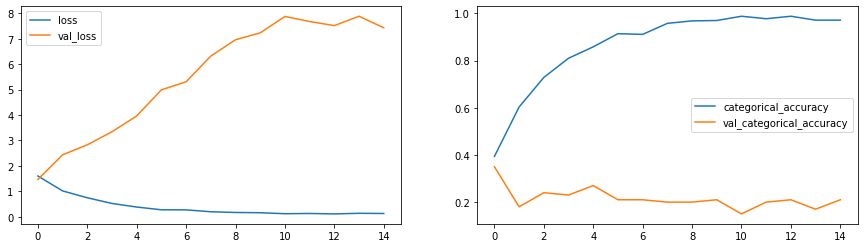

In [ ]:
# Plot the training and validation metrics

plot(history_model1)

##### Observations & Conclusions

- Model shows high accuracy for training and low accuracy for validation.
- Model is clearly overfitting. So we need to do data augmentation

# Model 2 - Augemented model

We will try to address the overfitting with augemetation and more epochs
We also increased dropout from 0.25 to 0.5 to see if helps in underfitting

 - Data Augmentation - to address overfitting
 - Batch Size 20 - 
 - Epoch 25 from 15 earlier
 - Dropout from 0.5 to 0.25

In [ ]:
# create the model and set hyperparameters

conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25) # no. of epochs changed to 25
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5) # dropout is 0.5
conv_3d2_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_60 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_60 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_90 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_60 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_61 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_61 (Activation)  (None, 10, 80, 80, 32)  

In [ ]:
# train the model with augmentation

print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.0954 - categorical_accuracy: 0.3590
Epoch 1: saving model to model_init_2022-06-1404_37_56.448288/model-00001-2.09536-0.35897-1.91608-0.24000.h5
34/34 [==============================] - 139s 4s/step - loss: 2.0954 - categorical_accuracy: 0.3590 - val_loss: 1.9161 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.6722 - categorical_accuracy: 0.4284
Epoch 2: saving model to model_init_2022-06-1404_37_56.448288/model-00002-1.67221-0.42836-2.72331-0.28000.h5
34/34 [==============================] - 135s 4s/step - loss: 1.6722 - categorical_accuracy: 0.4284 - val_loss: 2.7233 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.4797 - categorical_accuracy: 0.4849
Epoch 3: saving model to model_init_2022-06-1404_37_56.448288/model-00003-1.47966-0.48492-2.39769-0.41000.h5

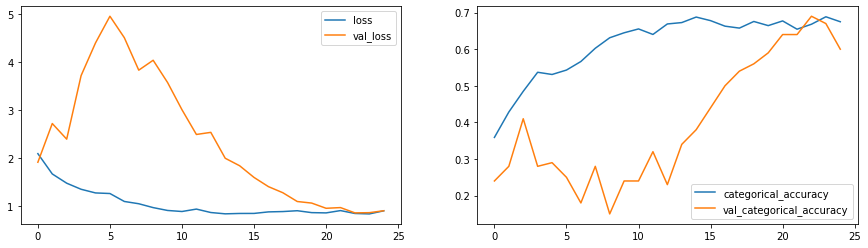

In [ ]:
# plot training and validation metrics

plot(history_model2)

### Observations & Conclusions

- Model is not overfitting and we get a good training and validation accuracy of around 70%. 
- Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see oscillations  in loss, let's try lowering the learning rate to 0.0002

# Model 3 
## With reduced image resoltuion and filter size

We will try to reduce the filter size and image resolution to see if get better results.
-  Reduce filter size to (2,2,2)
-  Image resoultion reduced to 120 x  120

In [ ]:
# derive a new model with new architecture

class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# define hyperparameters

conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)  # define reduced image size of 120 X 120
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)  # reduce filter size to (2,2,2)
conv_3d3_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_64 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_64 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_96 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_64 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_65 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_65 (Activation)  (None, 8, 60, 60, 32)   

In [ ]:
# train the model with augmentation

print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 2.1312 - categorical_accuracy: 0.3258
Epoch 1: saving model to model_init_2022-06-1405_34_09.205869/model-00001-2.13116-0.32579-1.82802-0.16000.h5
23/23 [==============================] - 106s 5s/step - loss: 2.1312 - categorical_accuracy: 0.3258 - val_loss: 1.8280 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.4827 - categorical_accuracy: 0.5000
Epoch 2: saving model to model_init_2022-06-1405_34_09.205869/model-00002-1.48274-0.50000-3.67260-0.10000.h5
23/23 [==============================] - 100s 5s/step - loss: 1.4827 - categorical_accuracy: 0.5000 - val_loss: 3.6726 - val_categorical_accuracy: 0.1000 - lr: 2.0000e-04
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.2325 - categorical_accuracy: 0.5686
Epoch 3: saving model to model_init_2022-06-1405_34_09.205869/model-00003-1.23248-0.56863-5.32272-0.

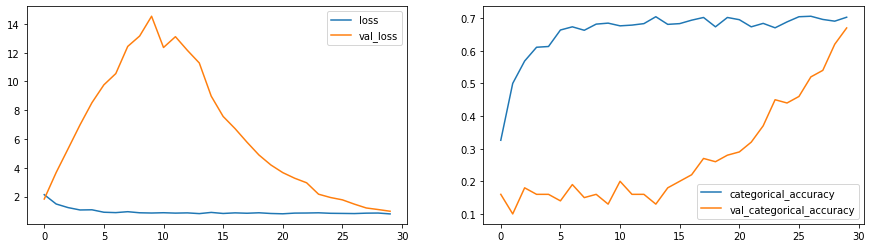

In [ ]:
# Plot training and validation metrics

plot(history_model3)

### Observations & Conclusions

- Model has better training and validation accuracy compared to earlier model.
- Also we were able to reduce the parameter size by half the earlier model. 
- Let's trying adding more layers

# Model 4 - Adding more layers

We will try add more layers to the model to see if it improves the model.

- 8 CNN layers
- Number of epochs increased to 30 to gain more accuracy
- Filter size now resotred to (3,3,3)

In [ ]:
# define new model architecure now with 8 CNN layers

class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        # CNN layer 1
        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # CNN layer 2
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # CNN layer 3
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # CNN layer 4
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # CNN layer 5
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # CNN layer 6
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # CNN layer 7
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # CNN layer 8
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# define model hyper paramters

conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)  # increased no. of neurons in dense layer
conv_3d4_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_68 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_68 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_102 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_69 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_69 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_103 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                   

In [ ]:
# train the model

print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.0050 - categorical_accuracy: 0.3733
Epoch 1: saving model to model_init_2022-06-1406_23_57.748485/model-00001-2.00496-0.37330-2.14359-0.16000.h5
34/34 [==============================] - 104s 3s/step - loss: 2.0050 - categorical_accuracy: 0.3733 - val_loss: 2.1436 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.7004 - categorical_accuracy: 0.4193
Epoch 2: saving model to model_init_2022-06-1406_23_57.748485/model-00002-1.70038-0.41931-2.56600-0.25000.h5
34/34 [==============================] - 103s 3s/step - loss: 1.7004 - categorical_accuracy: 0.4193 - val_loss: 2.5660 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.3989 - categorical_accuracy: 0.5053
Epoch 3: saving model to model_init_2022-06-1406_23_57.748485/model-00003-1.39890-0.50528-3.03715-0.23000.h5

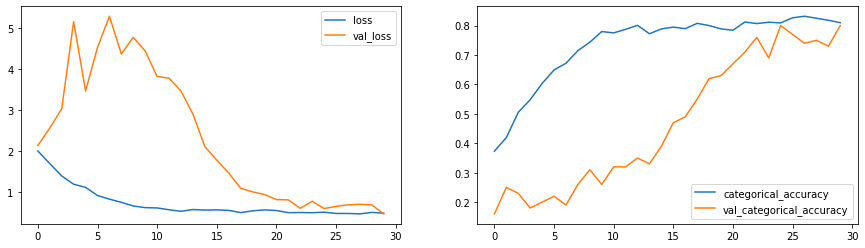

In [ ]:
# plot the training and validation metrics

plot(history_model4)

### Observations & Conclusions

- With more layers we do not see much performance improvement. We get a best validation accuracy of 76% 
- Let's try adding dropouts at the convolution layers

# Model 5 - Adding dropouts

We will try to add dropouts after some of the convolutional layers to reduce overfitting

- Use a dropout value of 0.25
- Kept number of CNN layers to 8
- Used image size of 120
- Reduced the number of epochs to 25 for optimum training time

In [ ]:
# crate a new model architcuture with more dropouts after convolutional layers

class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# define model hyperparameters

conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)  # Reduced epochs to 22
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25) # reduced dropout to 0.25
conv_3d5_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_76 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_76 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_112 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_77 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_77 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_113 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                   

In [ ]:
# train the model with augmented data

print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/22
34/34 [==============================] - ETA: 0s - loss: 1.8457 - categorical_accuracy: 0.3499
Epoch 1: saving model to model_init_2022-06-1407_16_24.706454/model-00001-1.84565-0.34992-1.75598-0.23000.h5
34/34 [==============================] - 103s 3s/step - loss: 1.8457 - categorical_accuracy: 0.3499 - val_loss: 1.7560 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/22
34/34 [==============================] - ETA: 0s - loss: 1.3571 - categorical_accuracy: 0.4827
Epoch 2: saving model to model_init_2022-06-1407_16_24.706454/model-00002-1.35709-0.48265-1.83688-0.21000.h5
34/34 [==============================] - 103s 3s/step - loss: 1.3571 - categorical_accuracy: 0.4827 - val_loss: 1.8369 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/22
34/34 [==============================] - ETA: 0s - loss: 1.1462 - categorical_accuracy: 0.5732
Epoch 3: saving model to model_init_2022-06-1407_16_24.706454/model-00003-1.14618-0.57315-2.06786-0.33000.h5

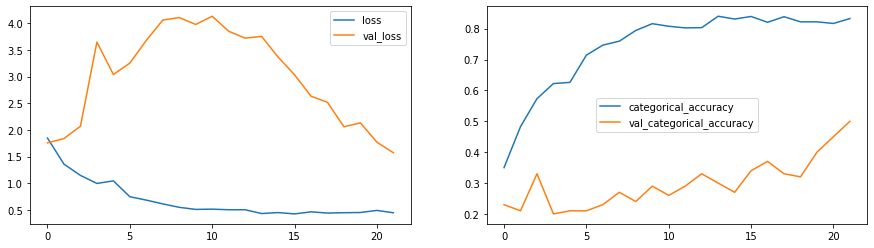

In [ ]:
# Plot training and validation metrics

plot(history_model5)

### Observations & Conclusions

- Adding dropouts has further reduced validation accuracy and is not able to learn  generalizable features
- Till now, we were expermenting models with more than one million parameters. We can try with reduced model size and check performance.

# Model 6 - reducing the number of parameters
- Reduce the no. of CNN layers to 4.
- Reduce the image resolution to 100 X 100.
- Reduce filter size to 2.
- Increase number of epochs to 30

In [ ]:
# building model with reduced number of layers

class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# model with reduced parameters

conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)  # Reduced size of image - 100 X 100
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)    # increased no. of epochs
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)  # Reduced no. of neurons in dense layer to 128
conv_3d6_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_84 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_84 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_122 (Ba  (None, 16, 100, 100, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_76 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_85 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_85 (Activation)  (None, 8, 50, 50, 32)   

In [ ]:
# train the model

print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.8353 - categorical_accuracy: 0.3544
Epoch 1: saving model to model_init_2022-06-1407_56_11.773780/model-00001-1.83530-0.35445-1.87548-0.16000.h5
34/34 [==============================] - 97s 3s/step - loss: 1.8353 - categorical_accuracy: 0.3544 - val_loss: 1.8755 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.2693 - categorical_accuracy: 0.5113
Epoch 2: saving model to model_init_2022-06-1407_56_11.773780/model-00002-1.26926-0.51131-2.78201-0.15000.h5
34/34 [==============================] - 96s 3s/step - loss: 1.2693 - categorical_accuracy: 0.5113 - val_loss: 2.7820 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.0818 - categorical_accuracy: 0.5882
Epoch 3: saving model to model_init_2022-06-1407_56_11.773780/model-00003-1.08183-0.58824-4.39498-0.160

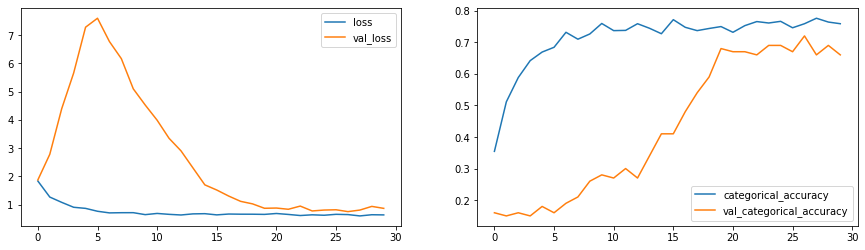

In [ ]:
# Plot training and validation metrics

plot(history_model6)

### Observations & Conclusions

- For the above low memory foot print model the best validation accuracy obtained is 77%.
- Let us try with reduced parameters

# Model 7

- Reducing the number of parameters
- Reducing the no. of neurons

In [ ]:
# Building another model with reduced parameters

class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# Model with reduced parameters

conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)  # reduced epoch
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25) # reduced no. of neurons
conv_3d7_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_88 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_88 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_128 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_80 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_89 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_89 (Activation)  (None, 8, 60, 60, 32)   

In [ ]:
# train the model

print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8110 - categorical_accuracy: 0.3695
Epoch 1: saving model to model_init_2022-06-1408_59_32.520524/model-00001-1.81100-0.36953-2.09229-0.16000.h5
34/34 [==============================] - 93s 3s/step - loss: 1.8110 - categorical_accuracy: 0.3695 - val_loss: 2.0923 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2253 - categorical_accuracy: 0.5385
Epoch 2: saving model to model_init_2022-06-1408_59_32.520524/model-00002-1.22531-0.53846-3.14417-0.18000.h5
34/34 [==============================] - 92s 3s/step - loss: 1.2253 - categorical_accuracy: 0.5385 - val_loss: 3.1442 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.9560 - categorical_accuracy: 0.6199
Epoch 3: saving model to model_init_2022-06-1408_59_32.520524/model-00003-0.95604-0.61991-4.36259-0.190

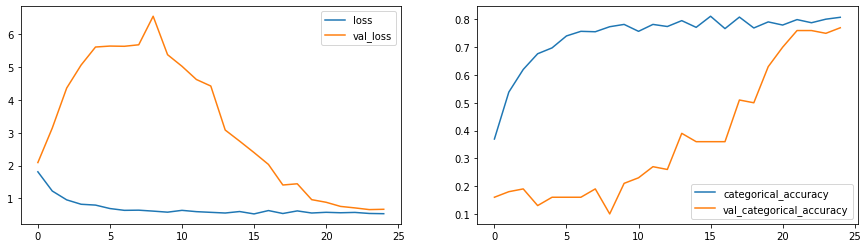

In [ ]:
# plot training and validation metrics

plot(history_model7)

### Observations & Conclusions

- For the above low memory foot print model the best validation accuracy of 77%
- We can revise the parameters to check performance

# Model 8

- We will further reduce the number of parameters
- The convolution 3D parameters will be changed

In [ ]:
# Change layer parameters

class ModelConv3D8(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# Define new model for convolution 3D

conv_3d8=ModelConv3D8()
conv_3d8.initialize_path(project_folder)
conv_3d8.initialize_image_properties(image_height=120,image_width=120)
conv_3d8.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)  # increase epoch
conv_3d8_model=conv_3d8.define_model(dense_neurons=64,dropout=0.25)
conv_3d8_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_92 (Conv3D)          (None, 16, 120, 120, 8)   656       
                                                                 
 activation_92 (Activation)  (None, 16, 120, 120, 8)   0         
                                                                 
 batch_normalization_134 (Ba  (None, 16, 120, 120, 8)  32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_84 (MaxPoolin  (None, 8, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_93 (Conv3D)          (None, 8, 60, 60, 16)     3472      
                                                                 
 activation_93 (Activation)  (None, 8, 60, 60, 16)   

In [ ]:
# train the model

print("Total Params:", conv_3d8_model.count_params())
history_model8=conv_3d8.train_model(conv_3d8_model,augment_data=True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - 220s 6s/step - loss: 1.9751 - categorical_accuracy: 0.2984 - val_loss: 1.4932 - val_categorical_accuracy: 0.4200

Epoch 00001: saving model to model_init_2019-03-1313_33_37.190087/model-00001-1.98941-0.29336-1.49321-0.42000.h5
Epoch 2/30
34/34 [==============================] - 88s 3s/step - loss: 1.4240 - categorical_accuracy: 0.4430 - val_loss: 1.1719 - val_categorical_accuracy: 0.5400

Epoch 00002: saving model to model_init_2019-03-1313_33_37.190087/model-00002-1.42481-0.44570-1.17192-0.54000.h5
Epoch 3/30
34/34 [==============================] - 90s 3s/step - loss: 1.2560 - categorical_accuracy: 0.4967 - val_loss: 1.1260 - val_categorical_accuracy: 0.5600

Epoch 00003: saving model to model_init_2019-03-1313_33_37.190087/model-00003-1.23420-0.50905-1.12604-0.56000.h5
Epoch 4/30
34/34 [==============================] - 91s 3s/step - loss: 1.1064 - categorical_accuracy: 0.5706 - val_loss: 1.0530 - val_categoric

34/34 [==============================] - 90s 3s/step - loss: 0.3807 - categorical_accuracy: 0.8745 - val_loss: 0.7095 - val_categorical_accuracy: 0.7700

Epoch 00030: saving model to model_init_2019-03-1313_33_37.190087/model-00030-0.36469-0.87557-0.70946-0.77000.h5


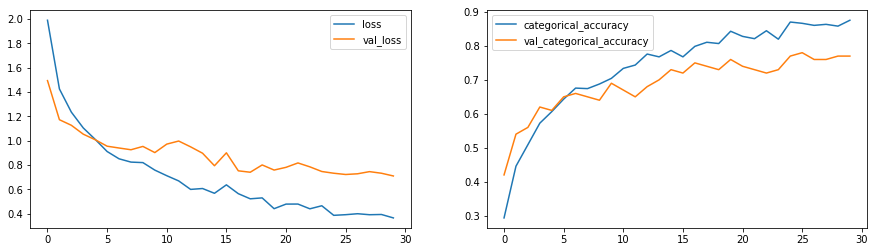

In [ ]:
# Plot training and validation metrics

plot(history_model8)

### Observations & Conclusions

- For the above low memory foot print model the best validation accuracy of 78% with training accuracy of 87%.
- The model seems to be overfitting.
- We will include RNN units in further models.

# Model 9

- We will now try out CNN- LSTM Model.
- Five CNN 2D layers.
- A single LSTM layer of 128 cells.

In [ ]:
# define the model

class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# Define RNN CNN joint model

rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)  # using 20 epochs
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25) # using 128 neurons in dense layer
rnn_cnn1_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32) 

In [ ]:
# train th emodel

print("Total Params:", rnn_cnn1_model.count_params())
history_model9=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - 185s 5s/step - loss: 1.4812 - categorical_accuracy: 0.3587 - val_loss: 1.3154 - val_categorical_accuracy: 0.4700

Epoch 00001: saving model to model_init_2019-03-1105_50_41.913699/model-00001-1.47905-0.36350-1.31544-0.47000.h5
Epoch 2/20
34/34 [==============================] - 97s 3s/step - loss: 1.1502 - categorical_accuracy: 0.5394 - val_loss: 1.0631 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_init_2019-03-1105_50_41.913699/model-00002-1.15262-0.53620-1.06311-0.47000.h5
Epoch 3/20
34/34 [==============================] - 101s 3s/step - loss: 1.1370 - categorical_accuracy: 0.5361 - val_loss: 1.9629 - val_categorical_accuracy: 0.2600

Epoch 00003: saving model to model_init_2019-03-1105_50_41.913699/model-00003-1.13109-0.53695-1.96287-0.26000.h5
Epoch 4/20
34/34 [==============================] - 100s 3s/step - loss: 0.9926 - categorical_accuracy: 0.6155 - val_loss: 1.9898 - val_catego

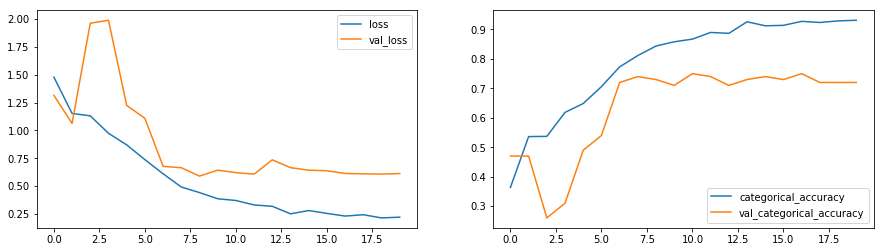

In [ ]:
# plot training and validation metrics

plot(history_model9)

### Observations & Conclusions

- For CNN - LSTM model we get a best validation accuracy of 75% and training accuracy of around 93%.
- As we see overfitting, let us augment the data with a small amount of rotation and with the same model.

# Augmentated Model

- Augment the above model
- Run with rotated pics in the augmentation

In [ ]:
# build augmented model

class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height)) # rotate pics
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [ ]:
#class Test(ModelBuilderMoreAugmentation):
#    def define_model(self):
#        pass

#test_generator=Test()
#test_generator.initialize_path(project_folder)
#test_generator.initialize_image_properties(image_height=160,image_width=160)
#test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

#g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
#batch_data, batch_labels=next(g)
#fig, axes = plt.subplots(nrows=1, ncols=2)
#axes[0].imshow(batch_data[0,29,:,:,:])   
#axes[1].imshow(batch_data[3,29,:,:,:])   

# Model 10

- Increased Filter size to 3
- Increased image resolution to 160 X 160
- Similar to Model 2

In [ ]:
# define model with increased filters and size with augmentation

class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# build the model

conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=160,image_width=160)
conv_3d10.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d10_model=conv_3d10.define_model(dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_96 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_96 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_145 (Ba  (None, 20, 160, 160, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_88 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_97 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_97 (Activation)  (None, 10, 80, 80, 32)  

In [ ]:
# train the model

print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 3638981
Epoch 1/30
34/34 [==============================] - 242s 7s/step - loss: 2.0054 - categorical_accuracy: 0.3709 - val_loss: 1.4889 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2019-03-1515_38_46.998496/model-00001-2.00150-0.37179-1.48888-0.51000.h5
Epoch 2/30
34/34 [==============================] - 138s 4s/step - loss: 1.3446 - categorical_accuracy: 0.5364 - val_loss: 0.9051 - val_categorical_accuracy: 0.7200

Epoch 00002: saving model to model_init_2019-03-1515_38_46.998496/model-00002-1.31829-0.54148-0.90512-0.72000.h5
Epoch 3/30
34/34 [==============================] - 139s 4s/step - loss: 1.2107 - categorical_accuracy: 0.5843 - val_loss: 0.8590 - val_categorical_accuracy: 0.7200

Epoch 00003: saving model to model_init_2019-03-1515_38_46.998496/model-00003-1.18664-0.59050-0.85905-0.72000.h5
Epoch 4/30
34/34 [==============================] - 140s 4s/step - loss: 1.0154 - categorical_accuracy: 0.6255 - val_loss: 0.8520 - val_categ

34/34 [==============================] - 140s 4s/step - loss: 0.3922 - categorical_accuracy: 0.8572 - val_loss: 0.5976 - val_categorical_accuracy: 0.8500

Epoch 00030: saving model to model_init_2019-03-1515_38_46.998496/model-00030-0.37248-0.86199-0.59757-0.85000.h5


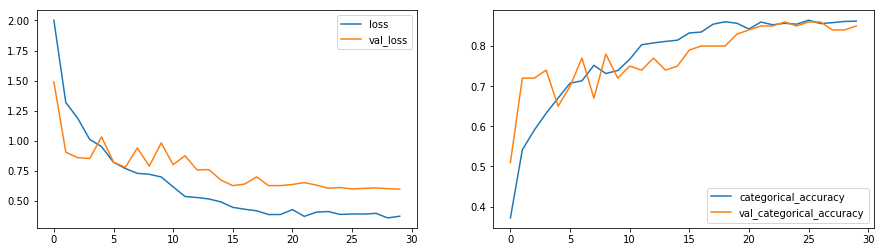

In [ ]:
# plot training and validation metrics

plot(history_model10)

### Observations & Conclusions

- Model has given a good accuracy of around 85% for both training and validation.
- We need to reduce parameters and check.

# Model 11

- Reduce filter size to 2
- Reduce image resolution to  120 X 120 Image resolution 
- Similar to Model 3

In [ ]:
# build model with changed parameters

class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# define the model

conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120) # Reduced size
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d11_model=conv_3d11.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)  # Reduced filter
conv_3d11_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_100 (Conv3D)         (None, 16, 120, 120, 16)  400       
                                                                 
 activation_100 (Activation)  (None, 16, 120, 120, 16)  0        
                                                                 
 batch_normalization_151 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_92 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_101 (Conv3D)         (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_101 (Activation)  (None, 8, 60, 60, 32)  

In [ ]:
# train the model

print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - 96s 4s/step - loss: 2.3126 - categorical_accuracy: 0.3107 - val_loss: 1.1722 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_2019-03-1610_29_13.078401/model-00001-2.37693-0.29035-1.17217-0.53000.h5
Epoch 2/30
23/23 [==============================] - 86s 4s/step - loss: 1.6542 - categorical_accuracy: 0.4392 - val_loss: 1.1440 - val_categorical_accuracy: 0.5600

Epoch 00002: saving model to model_init_2019-03-1610_29_13.078401/model-00002-1.69388-0.42383-1.14399-0.56000.h5
Epoch 3/30
23/23 [==============================] - 89s 4s/step - loss: 1.4634 - categorical_accuracy: 0.4940 - val_loss: 1.0317 - val_categorical_accuracy: 0.6100

Epoch 00003: saving model to model_init_2019-03-1610_29_13.078401/model-00003-1.41239-0.50679-1.03166-0.61000.h5
Epoch 4/30
23/23 [==============================] - 89s 4s/step - loss: 1.2362 - categorical_accuracy: 0.5701 - val_loss: 0.9686 - val_categoric

23/23 [==============================] - 91s 4s/step - loss: 0.5336 - categorical_accuracy: 0.8008 - val_loss: 0.7835 - val_categorical_accuracy: 0.7300

Epoch 00030: saving model to model_init_2019-03-1610_29_13.078401/model-00030-0.49944-0.81900-0.78350-0.73000.h5


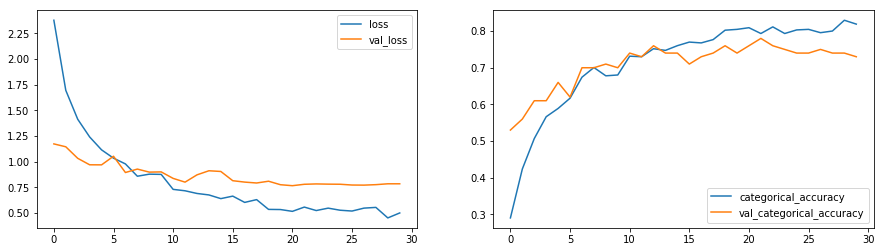

In [ ]:
# plot training and validation metrics

plot(history_model11)

### Observations & Conclusions

- Model has shown better accuracy
- We will try with more parameters

# Model 12

- Adding more layers 
- Similar to model 4

In [ ]:
# define model with more layers

class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# build the model

conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)  # Increased filter size
conv_3d12_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_104 (Conv3D)         (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_104 (Activation)  (None, 16, 120, 120, 16)  0        
                                                                 
 batch_normalization_157 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_105 (Conv3D)         (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_105 (Activation)  (None, 16, 120, 120, 16)  0        
                                                                 
 batch_normalization_158 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                   

In [ ]:
# train the model

print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - 196s 6s/step - loss: 2.1942 - categorical_accuracy: 0.3160 - val_loss: 2.1050 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2019-03-1602_59_28.450657/model-00001-2.20448-0.31976-2.10499-0.36000.h5
Epoch 2/30
34/34 [==============================] - 96s 3s/step - loss: 1.6542 - categorical_accuracy: 0.4363 - val_loss: 1.7584 - val_categorical_accuracy: 0.4300

Epoch 00002: saving model to model_init_2019-03-1602_59_28.450657/model-00002-1.64910-0.43891-1.75837-0.43000.h5
Epoch 3/30
34/34 [==============================] - 99s 3s/step - loss: 1.4116 - categorical_accuracy: 0.5007 - val_loss: 1.2344 - val_categorical_accuracy: 0.5400

Epoch 00003: saving model to model_init_2019-03-1602_59_28.450657/model-00003-1.42322-0.50075-1.23443-0.54000.h5
Epoch 4/30
34/34 [==============================] - 99s 3s/step - loss: 1.2196 - categorical_accuracy: 0.5784 - val_loss: 1.6662 - val_categori


Epoch 00029: saving model to model_init_2019-03-1602_59_28.450657/model-00029-0.43063-0.85219-0.64634-0.80000.h5
Epoch 30/30
34/34 [==============================] - 98s 3s/step - loss: 0.4531 - categorical_accuracy: 0.8425 - val_loss: 0.6437 - val_categorical_accuracy: 0.7900

Epoch 00030: saving model to model_init_2019-03-1602_59_28.450657/model-00030-0.42906-0.84691-0.64368-0.79000.h5


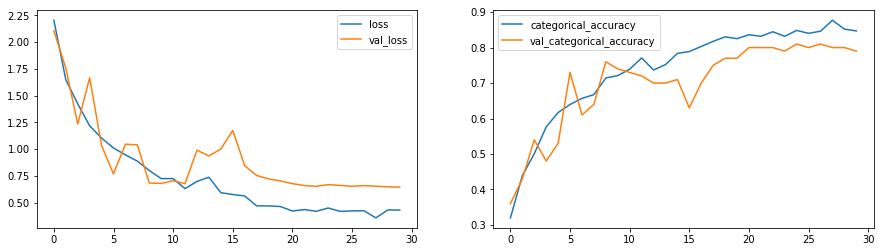

In [ ]:
# plot training and validation metrics

plot(history_model12)

### Observations & Conclusions
- Accuracy in training and validation remains same as previous model.
- We will try with changes in other parameters.

# Model 13

- Adding dropouts
- Similar to Model 5

In [ ]:
# Define the model

class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# Build the model

conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=120,image_width=120)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)   # Dropouts added
conv_3d13_model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_112 (Conv3D)         (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_112 (Activation)  (None, 16, 120, 120, 16)  0        
                                                                 
 batch_normalization_167 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_113 (Conv3D)         (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_113 (Activation)  (None, 16, 120, 120, 16)  0        
                                                                 
 batch_normalization_168 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                   

In [ ]:
# train the model

print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - 125s 4s/step - loss: 1.9786 - categorical_accuracy: 0.3300 - val_loss: 3.2322 - val_categorical_accuracy: 0.1900

Epoch 00001: saving model to model_init_2019-03-1615_04_13.612627/model-00001-2.01066-0.31750-3.23223-0.19000.h5
Epoch 2/25
34/34 [==============================] - 98s 3s/step - loss: 1.6215 - categorical_accuracy: 0.4235 - val_loss: 3.7893 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model_init_2019-03-1615_04_13.612627/model-00002-1.62012-0.42157-3.78929-0.22000.h5
Epoch 3/25
34/34 [==============================] - 98s 3s/step - loss: 1.4399 - categorical_accuracy: 0.4606 - val_loss: 3.4880 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_2019-03-1615_04_13.612627/model-00003-1.41740-0.47210-3.48800-0.23000.h5
Epoch 4/25
34/34 [==============================] - 98s 3s/step - loss: 1.3233 - categorical_accuracy: 0.4989 - val_loss: 3.1878 - val_categori

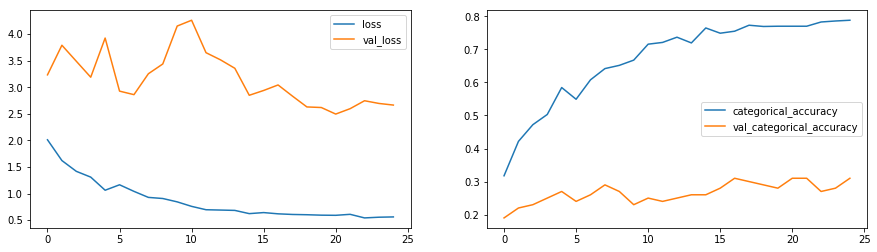

In [ ]:
# plot trainining and validation metrics

plot(history_model13)

### Observations & Conclusions

- The model is overfitting
- We need to reduce parameters and build another model

# Model 14
- Reducing network parameters 
- Similar to Model 6

In [ ]:
# Define model

class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# Build the model

conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=100,image_width=100) # Reduce image resolution
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d14_model=conv_3d14.define_model(dense_neurons=128,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_120 (Conv3D)         (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_120 (Activation)  (None, 16, 100, 100, 16)  0        
                                                                 
 batch_normalization_177 (Ba  (None, 16, 100, 100, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_104 (MaxPooli  (None, 8, 50, 50, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_121 (Conv3D)         (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_121 (Activation)  (None, 8, 50, 50, 32)  

In [ ]:
# train the model

print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - 94s 3s/step - loss: 1.8539 - categorical_accuracy: 0.3322 - val_loss: 1.2226 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2019-03-1616_05_42.331421/model-00001-1.88243-0.32805-1.22261-0.51000.h5
Epoch 2/30
34/34 [==============================] - 75s 2s/step - loss: 1.2911 - categorical_accuracy: 0.5129 - val_loss: 1.0278 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_init_2019-03-1616_05_42.331421/model-00002-1.25660-0.51735-1.02785-0.57000.h5
Epoch 3/30
34/34 [==============================] - 87s 3s/step - loss: 1.0534 - categorical_accuracy: 0.5927 - val_loss: 1.0887 - val_categorical_accuracy: 0.5900

Epoch 00003: saving model to model_init_2019-03-1616_05_42.331421/model-00003-1.04921-0.59502-1.08865-0.59000.h5
Epoch 4/30
34/34 [==============================] - 86s 3s/step - loss: 0.9657 - categorical_accuracy: 0.6453 - val_loss: 0.9976 - val_categorica

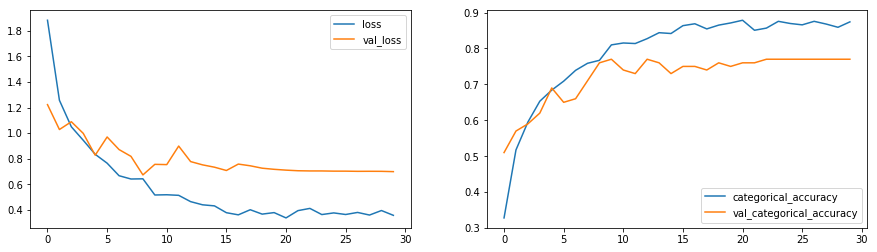

In [ ]:
# plot training and validation metrics

plot(history_model14)

### Observations & Conclusions

- The model is performing better than previous one.
- We need to check performance with changes to network parameters.

# Model 15
- Reducing network parameters 
- Similar to model 7

In [ ]:
# Define model

class ModelConv3D15(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# build the model

conv_3d15=ModelConv3D15()
conv_3d15.initialize_path(project_folder)
conv_3d15.initialize_image_properties(image_height=120,image_width=120) # increased image resolution
conv_3d15.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)   # reduced epochs
conv_3d15_model=conv_3d15.define_model(dense_neurons=64,dropout=0.25)   # reduced neurons in dense layer
conv_3d15_model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_124 (Conv3D)         (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_124 (Activation)  (None, 16, 120, 120, 16)  0        
                                                                 
 batch_normalization_183 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_108 (MaxPooli  (None, 8, 60, 60, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_125 (Conv3D)         (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_125 (Activation)  (None, 8, 60, 60, 32)  

In [ ]:
# train the model

print("Total Params:", conv_3d15_model.count_params())
history_model15=conv_3d15.train_model(conv_3d15_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - 101s 3s/step - loss: 1.8962 - categorical_accuracy: 0.3216 - val_loss: 1.4599 - val_categorical_accuracy: 0.4800

Epoch 00001: saving model to model_init_2019-03-1617_00_15.029524/model-00001-1.88427-0.32127-1.45992-0.48000.h5
Epoch 2/25
34/34 [==============================] - 82s 2s/step - loss: 1.3983 - categorical_accuracy: 0.4573 - val_loss: 1.2260 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model_init_2019-03-1617_00_15.029524/model-00002-1.38430-0.46456-1.22598-0.53000.h5
Epoch 3/25
34/34 [==============================] - 94s 3s/step - loss: 1.1682 - categorical_accuracy: 0.5368 - val_loss: 1.2060 - val_categorical_accuracy: 0.5700

Epoch 00003: saving model to model_init_2019-03-1617_00_15.029524/model-00003-1.16263-0.53771-1.20604-0.57000.h5
Epoch 4/25
34/34 [==============================] - 93s 3s/step - loss: 1.0644 - categorical_accuracy: 0.5964 - val_loss: 1.0325 - val_categoric

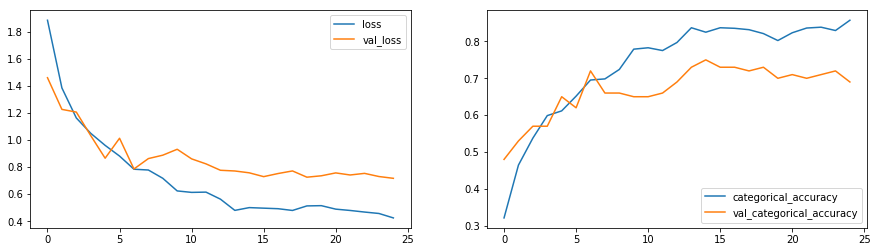

In [ ]:
# plot training and validation metrics

plot(history_model15)

### Observations & Conclusions

- Model is overfitting.
- It is performing poorer than previous model.
- We will continue trying out network parametric changes.

# Model 16
- Reducing network parameters.
- Similar to Model 8.

In [ ]:
# define the model

class ModelConv3D16(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# build the model

conv_3d16=ModelConv3D16()
conv_3d16.initialize_path(project_folder)
conv_3d16.initialize_image_properties(image_height=120,image_width=120)
conv_3d16.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)   # increased epochs
conv_3d16_model=conv_3d16.define_model(dense_neurons=64,dropout=0.25)
conv_3d16_model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_128 (Conv3D)         (None, 16, 120, 120, 8)   656       
                                                                 
 activation_128 (Activation)  (None, 16, 120, 120, 8)  0         
                                                                 
 batch_normalization_189 (Ba  (None, 16, 120, 120, 8)  32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_112 (MaxPooli  (None, 8, 60, 60, 8)     0         
 ng3D)                                                           
                                                                 
 conv3d_129 (Conv3D)         (None, 8, 60, 60, 16)     3472      
                                                                 
 activation_129 (Activation)  (None, 8, 60, 60, 16)  

In [ ]:
print("Total Params:", conv_3d16_model.count_params())
history_model16=conv_3d16.train_model(conv_3d16_model,augment_data=True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - 188s 6s/step - loss: 1.9651 - categorical_accuracy: 0.2789 - val_loss: 1.3883 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_2019-03-1607_47_08.840041/model-00001-1.98495-0.27753-1.38834-0.53000.h5
Epoch 2/30
34/34 [==============================] - 89s 3s/step - loss: 1.3860 - categorical_accuracy: 0.4853 - val_loss: 1.2226 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model_init_2019-03-1607_47_08.840041/model-00002-1.38607-0.48492-1.22261-0.53000.h5
Epoch 3/30
34/34 [==============================] - 90s 3s/step - loss: 1.3189 - categorical_accuracy: 0.5007 - val_loss: 1.0697 - val_categorical_accuracy: 0.5800

Epoch 00003: saving model to model_init_2019-03-1607_47_08.840041/model-00003-1.30081-0.50075-1.06971-0.58000.h5
Epoch 4/30
34/34 [==============================] - 90s 3s/step - loss: 1.1629 - categorical_accuracy: 0.5331 - val_loss: 1.0790 - val_categoric


Epoch 00029: saving model to model_init_2019-03-1607_47_08.840041/model-00029-0.56069-0.78808-0.72675-0.74000.h5
Epoch 30/30
34/34 [==============================] - 87s 3s/step - loss: 0.5599 - categorical_accuracy: 0.7991 - val_loss: 0.7277 - val_categorical_accuracy: 0.7400

Epoch 00030: saving model to model_init_2019-03-1607_47_08.840041/model-00030-0.54447-0.80241-0.72770-0.74000.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 3.200000037395512e-07.


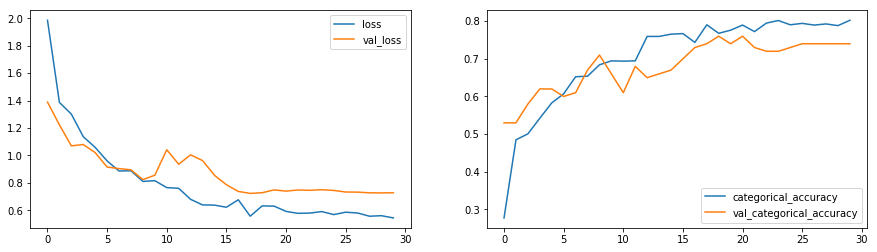

In [ ]:
# plot training and validation metrics

plot(history_model16)

### Observations & Conclusions

- Model has reduced overfitting compared to previous.
- Accuracy has also reduced.
- Try with LSTM and GRU

# Model 17
- CNN LSTM with GRU 
- Similar to Model 9

In [ ]:
# define the model

class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)    #changes to frames and epochs
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25) # changes to no. of neurons and inclusion of LSTM cells
rnn_cnn2_model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 18, 60, 60, 32) 

In [ ]:
# train the model

print("Total Params:", rnn_cnn2_model.count_params())
history_model17=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573541
Epoch 1/20
34/34 [==============================] - 208s 6s/step - loss: 1.4934 - categorical_accuracy: 0.3418 - val_loss: 1.1111 - val_categorical_accuracy: 0.6200

Epoch 00001: saving model to model_init_2019-03-1706_40_14.783128/model-00001-1.49392-0.34615-1.11110-0.62000.h5
Epoch 2/20
34/34 [==============================] - 100s 3s/step - loss: 1.0478 - categorical_accuracy: 0.5791 - val_loss: 0.9681 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to model_init_2019-03-1706_40_14.783128/model-00002-1.05931-0.57692-0.96808-0.61000.h5
Epoch 3/20
34/34 [==============================] - 101s 3s/step - loss: 0.9091 - categorical_accuracy: 0.6472 - val_loss: 0.9252 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to model_init_2019-03-1706_40_14.783128/model-00003-0.90214-0.65083-0.92517-0.65000.h5
Epoch 4/20
34/34 [==============================] - 103s 3s/step - loss: 0.7560 - categorical_accuracy: 0.7208 - val_loss: 0.9613 - val_categ

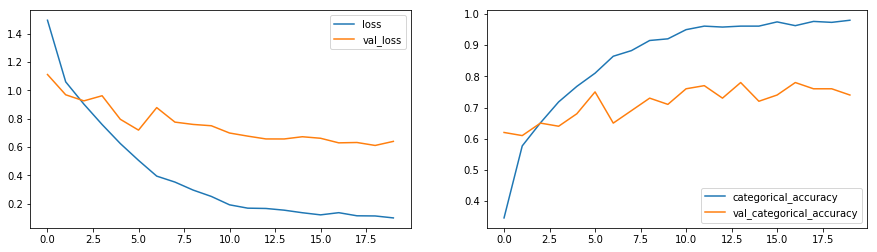

In [ ]:
# plot training and validation metrics

plot(history_model17)

###  Observations & Conclusions
- We see that overfitting is considerably less when we do more augmentation. 
- However there is not much improvement on accuracy
- Let us use a different approach

# Model 18
- Transfer Learning

In [ ]:
# import required libraries

from keras.applications import mobilenet

In [ ]:
# define transfer learning model

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
# build the model

rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)             

In [ ]:
# train the model

print("Total Params:", rnn_cnn_tl_model.count_params())
history_model18=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - 89s 672ms/step - loss: 1.4922 - categorical_accuracy: 0.3306 - val_loss: 1.3094 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2019-03-1609_17_55.216031/model-00001-1.49357-0.32956-1.30941-0.44000.h5
Epoch 2/20
133/133 [==============================] - 83s 623ms/step - loss: 1.1750 - categorical_accuracy: 0.5208 - val_loss: 1.2151 - val_categorical_accuracy: 0.4800

Epoch 00002: saving model to model_init_2019-03-1609_17_55.216031/model-00002-1.17305-0.52187-1.21509-0.48000.h5
Epoch 3/20
133/133 [==============================] - 83s 625ms/step - loss: 1.0349 - categorical_accuracy: 0.5985 - val_loss: 1.0923 - val_categorical_accuracy: 0.5500

Epoch 00003: saving model to model_init_2019-03-1609_17_55.216031/model-00003-1.03466-0.59879-1.09227-0.55000.h5
Epoch 4/20
133/133 [==============================] - 86s 645ms/step - loss: 0.8913 - categorical_accuracy: 0.6526 - val_loss: 1.

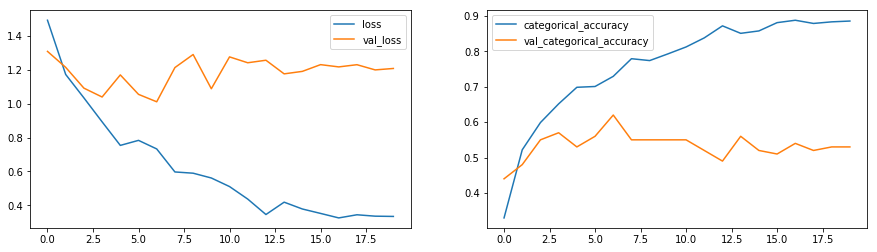

In [ ]:
# plot training and validation metrics

plot(history_model18)

### Observations & Conclusions

- We are not training the mobilenet weights and we see validation accuracy is very poor. 
- Let's train them as well and observe if there is performance improvement.

# Model 19 
- Transfer Learning with GRU and training all weights

In [ ]:
# define the model

from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
# build the model

rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)              

In [ ]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model19=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.1266 - categorical_accuracy: 0.5287 
Epoch 1: saving model to model_init_2022-06-1307_26_06.227651/model-00001-1.12664-0.52866-0.66243-0.73000.h5
133/133 [==============================] - 7673s 58s/step - loss: 1.1266 - categorical_accuracy: 0.5287 - val_loss: 0.6624 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.7196 - categorical_accuracy: 0.7398
Epoch 2: saving model to model_init_2022-06-1307_26_06.227651/model-00002-0.71956-0.73982-0.55175-0.76000.h5
133/133 [==============================] - 93s 699ms/step - loss: 0.7196 - categorical_accuracy: 0.7398 - val_loss: 0.5517 - val_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.5311 - categorical_accuracy: 0.8047
Epoch 3: saving model to model_init_2022-06-1307_26_06.227651/model-00003-0.53110-0.80468-0.3

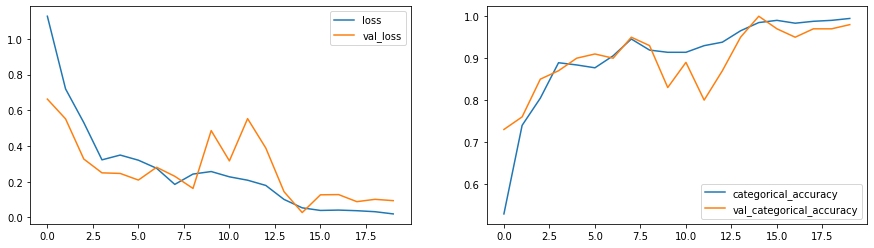

In [ ]:
# plot training and validation metrics

plot(history_model19)

### Observations & Conclusions
- This has the best performance
- It shows a training accuracy of **_99.47%_** and a validation accuracy of **_98%_**

# Conclusion

<ol>
<li>
We started our model building exercise with an experiment on getting the optimal parameters like image resolution, frame size and batch sizes.
</li>
<li>We have tried different models starting with a base model of CNN only and slowly building up by including RNN layers. We have also included transfer learning to check its performance in gesture recognition.</li>
<li>In all models, we checked different parameters and tested their performance on the available data. The CNN 2D models were generally overfitting with high training accuracy of around 90% and low validation accuracy of around 75% while a CNN 3D model gave around 85% with no overfitting. </li>
<li>CNNs with RNN proved better than only CNN models. Both CNN 2D and CNN 3D models with RNN showed similar accuracies.</li>
<li><em>Transfer Learning.  </em>We trained the models using transfer learning from MobileNet with GRU cells without and with training of transfer learning weights. The model with trained transfer learning weights provided the best accuracy. We achieved a <em>training accuracy</em> of <em><strong>99.47%</strong></em> and a <em>validation accuracy</em> of <em><strong>98%</strong></em>.</li>
</ol>

# Recommendation
<ol>
<li>Any machine learning model should be quickly deployed. So, using available resources like transfer learning is key to building and testing models. As seen in this study, transfer learning has proved to be better than any other models including complex ones with LSTM and GRU with CNN.</li>
<li>In the absence of a suitable transfer learning model, we should explore more options and layers of the different available CNN and RNN models including various activation functions and residual network options.</li>
</ol>

# Loading model and Testing

In [ ]:
import time
from keras.models import load_model
model = load_model('/content/model_init_2022-06-1307_26_06.227651/model-00020-0.01944-0.99472-0.09372-0.98000.h5')

In [ ]:
test_generator=RNNCNN_TL2()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [ ]:
batch_labels

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]])

In [ ]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[3 0 0 3 0]
